In [35]:
import warnings

warnings.filterwarnings("ignore")

## Data

In [36]:
from sktime.datasets import load_macroeconomic
from sktime.forecasting.model_selection import temporal_train_test_split

data = load_macroeconomic()
y = data["unemp"]
X = data.drop(columns=["unemp"])

y_train, y_test, X_train, X_test = temporal_train_test_split(y, X, test_size=40)

(<Figure size 1600x400 with 1 Axes>, <AxesSubplot: ylabel='unemp'>)

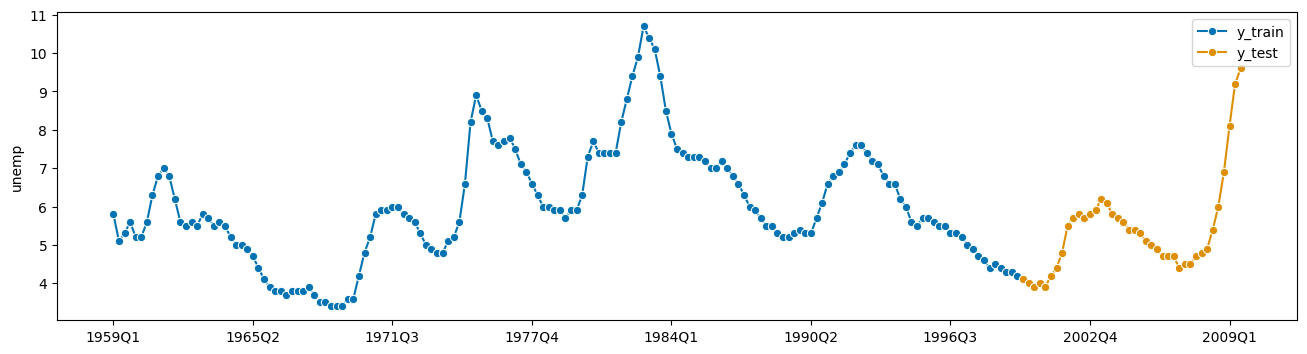

In [37]:
from sktime.utils.plotting import plot_series

plot_series(y_train, y_test, labels=["y_train", "y_test"])

## Cross-validation

In [16]:
import numpy as np
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.model_selection import (
    ExpandingWindowSplitter,
    SlidingWindowSplitter,
)
from sktime.utils.plotting import plot_windows

fh = ForecastingHorizon(np.arange(1, 41), is_relative=True)

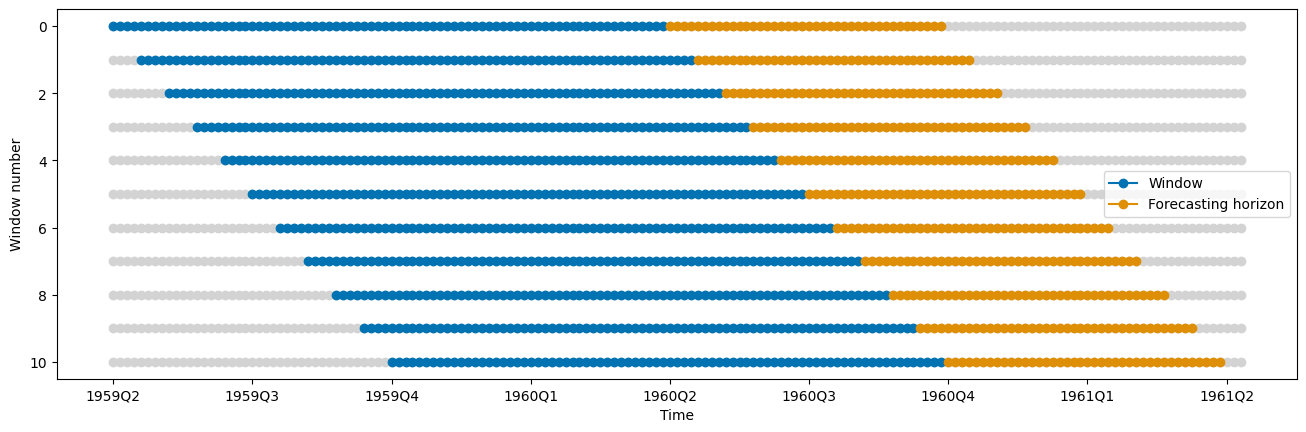

In [21]:
cv = SlidingWindowSplitter(fh=fh, window_length=80, step_length=4)
plot_windows(cv=cv, y=y_train)

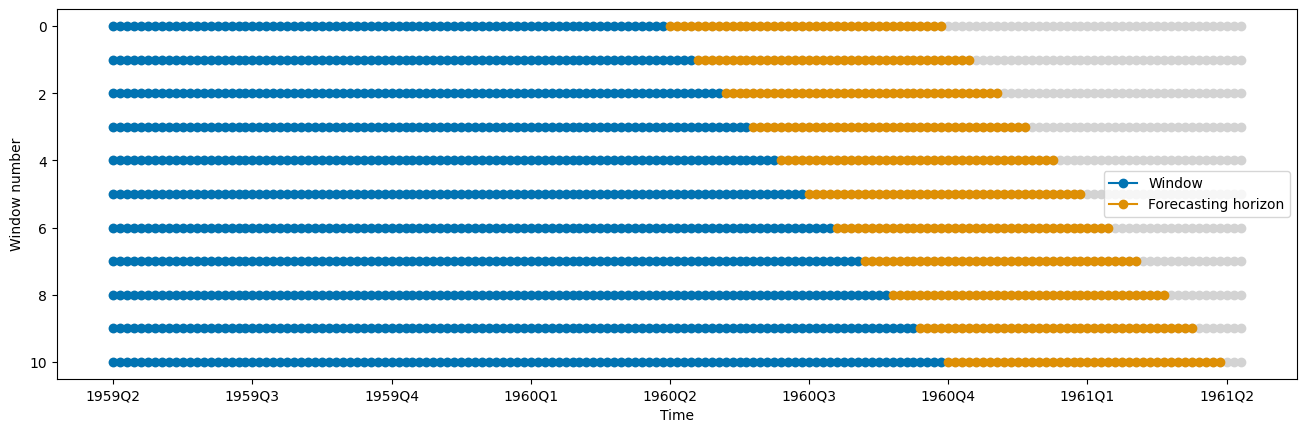

In [23]:
cv = ExpandingWindowSplitter(fh=fh, initial_window=80, step_length=4)
plot_windows(cv=cv, y=y_train)

In [24]:
# get number of total splits (folds)
cv.get_n_splits(y=y_train)

11

## Grid search

In [74]:
from sktime.forecasting.exp_smoothing import ExponentialSmoothing
from sktime.forecasting.model_selection import ForecastingGridSearchCV
from sktime.performance_metrics.forecasting import MeanSquaredError


forecaster = ExponentialSmoothing()
param_grid = {
    "sp": [4, 8, 12, 16, 20, 24, 28, 32, 36],
    "seasonal": ["add", "mul"],
    "trend": ["add", "mul"],
    "damped_trend": [True, False],
}
gscv = ForecastingGridSearchCV(
    forecaster=forecaster,
    param_grid=param_grid,
    cv=cv,
    n_jobs=-1,
    verbose=1,
    scoring=MeanSquaredError(),
)
gscv.fit(y_train)
y_pred = gscv.predict(fh=fh)

Fitting 11 folds for each of 72 candidates, totalling 792 fits


(<Figure size 1600x400 with 1 Axes>, <AxesSubplot: ylabel='unemp'>)

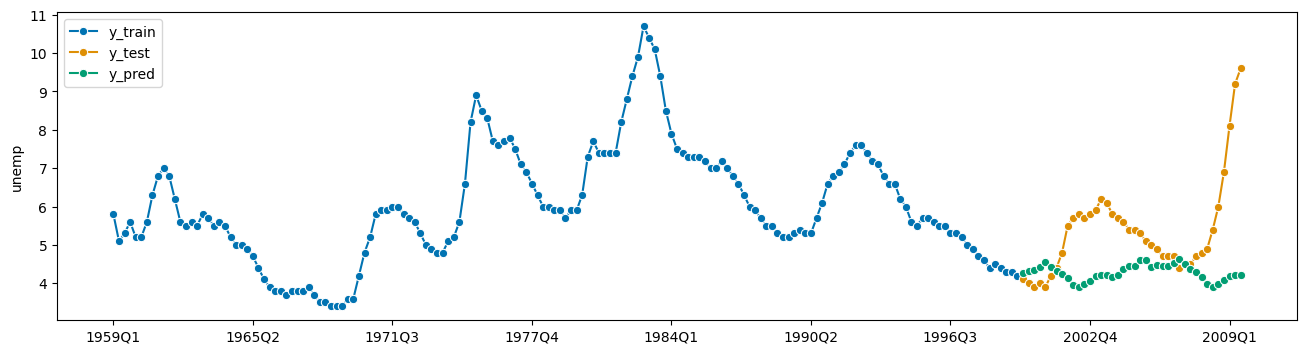

In [69]:
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])

In [56]:
from sktime.performance_metrics.forecasting import mean_squared_error

round(mean_squared_error(y_true=y_test, y_pred=y_pred), 4)

3.0156

In [49]:
gscv.best_params_

{'damped_trend': True, 'seasonal': 'mul', 'sp': 24, 'trend': 'add'}

In [50]:
gscv.best_forecaster_

ExponentialSmoothing(damped_trend=True, seasonal='mul', sp=24, trend='add')

In [52]:
gscv.cv_results_.head()

,mean_test_MeanSquaredError,mean_fit_time,mean_pred_time,params,rank_test_MeanSquaredError
0,8.067965,0.139452,0.005716,"{'damped_trend': True, 'seasonal': 'add', 'sp'...",13.0
1,395.043901,0.212512,0.005806,"{'damped_trend': True, 'seasonal': 'add', 'sp'...",53.0
2,8.073082,0.145976,0.006160,"{'damped_trend': True, 'seasonal': 'add', 'sp'...",14.0
3,710.769574,0.212664,0.006140,"{'damped_trend': True, 'seasonal': 'add', 'sp'...",57.0
4,7.963670,0.128994,0.005654,"{'damped_trend': True, 'seasonal': 'add', 'sp'...",10.0


## Grid search with pipeline

In [129]:
from sklearn.preprocessing import PowerTransformer, RobustScaler, MinMaxScaler
from sktime.forecasting.compose import TransformedTargetForecaster
from sktime.transformations.series.adapt import TabularToSeriesAdaptor
from sktime.transformations.series.detrend import Deseasonalizer, Detrender

forecaster = TransformedTargetForecaster(
    steps=[
        ("detrender", Detrender()),
        ("deseasonalizer", Deseasonalizer()),
        ("minmax", TabularToSeriesAdaptor(MinMaxScaler((1, 10)))),
        ("power", TabularToSeriesAdaptor(PowerTransformer())),
        ("scaler", TabularToSeriesAdaptor(RobustScaler())),
        ("forecaster", ExponentialSmoothing()),
    ]
)

# using dunder notation to access inner objects/params as in sklearn
param_grid = {
    # deseasonalizer
    "deseasonalizer__model": ["multiplicative", "additive"],
    # power
    "power__transformer__method": ["yeo-johnson", "box-cox"],
    "power__transformer__standardize": [True, False],
    # forecaster
    "forecaster__sp": [4, 8, 12, 16, 20, 24, 28, 32, 36],
    "forecaster__seasonal": ["add", "mul"],
    "forecaster__trend": ["add", "mul"],
    "forecaster__damped_trend": [True, False],
}

gscv = ForecastingGridSearchCV(
    forecaster=forecaster,
    param_grid=param_grid,
    cv=cv,
    n_jobs=-1,
    verbose=1,
    scoring=MeanSquaredError(),  # set custom scoring function
)
gscv.fit(y_train)
y_pred = gscv.predict(fh=fh)

Fitting 11 folds for each of 576 candidates, totalling 6336 fits


In [65]:
from sktime.performance_metrics.forecasting import mean_squared_error

round(mean_squared_error(y_true=y_test, y_pred=y_pred), 4)

2.8727

In [66]:
gscv.best_params_

{'deseasonalizer__model': 'additive',
 'forecaster__damped_trend': True,
 'forecaster__seasonal': 'add',
 'forecaster__sp': 24,
 'forecaster__trend': 'add',
 'power__transformer__method': 'yeo-johnson',
 'power__transformer__standardize': False}

(<Figure size 1600x400 with 1 Axes>, <AxesSubplot: ylabel='unemp'>)

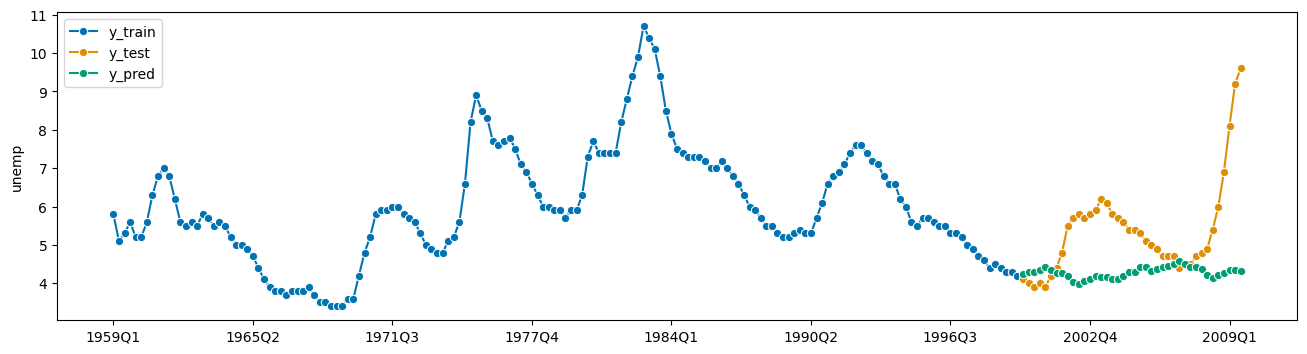

In [67]:
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])

## Model selection


In [128]:
from sktime.forecasting.theta import ThetaForecaster
from sktime.forecasting.trend import STLForecaster
from sktime.forecasting.naive import NaiveForecaster

forecaster = TransformedTargetForecaster(
    steps=[
        ("detrender", Detrender()),
        ("deseasonalizer", Deseasonalizer()),
        ("scaler", TabularToSeriesAdaptor(RobustScaler())),
        ("minmax2", TabularToSeriesAdaptor(MinMaxScaler((1, 10)))),
        ("forecaster", NaiveForecaster()),
    ]
)

gscv = ForecastingGridSearchCV(
    forecaster=forecaster,
    param_grid=[
        {
            "scaler__transformer__with_scaling": [True, False],
            "forecaster": [NaiveForecaster(sp=12)],
            "forecaster__strategy": ["drift", "last", "mean"],
        },
        {
            "scaler__transformer__with_scaling": [True, False],
            "forecaster": [STLForecaster(sp=12)],
        },
        {
            "scaler__transformer__with_scaling": [True, False],
            "forecaster": [ThetaForecaster(sp=12)],
        },
    ],
    cv=cv,
    n_jobs=-1,
    error_score="raise",
)
gscv.fit(y)
gscv.best_params_

{'forecaster': NaiveForecaster(sp=12, strategy='drift'),
 'forecaster__strategy': 'drift',
 'scaler__transformer__with_scaling': True}

## Tuning implicite hyper-parameters.

An implicite hyper-parameter can be an architecture and design decision that has an impact on the model error metric. An example for an implicite hyperparameter can be the number of layers of an artificial neural network. For pipelining, there are two implicite hyper-parameters that we might want to tune.
1) Combination of transformers
2) Permutation of transformers

### Combination of transformers

Given a set of four different transformers, we would like to know which combination of the four transformers is having the best error. So in total there are 4² = 16 different combinations. We can use the `GridSearchCV` to find the best combination.

In [90]:
steps = [
    ("detrender", Detrender()),
    ("deseasonalizer", Deseasonalizer()),
    ("power", TabularToSeriesAdaptor(PowerTransformer())),
    ("scaler", TabularToSeriesAdaptor(RobustScaler())),
    ("forecaster", ExponentialSmoothing()),
]

In `sktime` there is a transformer composition called `OptionalPassthrough()` which gets a transformer as an argument and a param `passthrough: bool`. Setting `passthrough=True` will return an identity transformation for the given data. Setting `passthrough=False` will apply the given inner transformer on the data.

In [87]:
from sktime.transformations.series.compose import OptionalPassthrough

transformer = OptionalPassthrough(transformer=Detrender(), passthrough=True)
transformer.fit_transform(y_train).head()

1959Q1    5.8
1959Q2    5.1
1959Q3    5.3
1959Q4    5.6
1960Q1    5.2
Freq: Q-DEC, Name: unemp, dtype: float64

In [88]:
y_train.head()

1959Q1    5.8
1959Q2    5.1
1959Q3    5.3
1959Q4    5.6
1960Q1    5.2
Freq: Q-DEC, Name: unemp, dtype: float64

In [89]:
transformer = OptionalPassthrough(transformer=Detrender(), passthrough=False)
transformer.fit_transform(y_train).head()

1959Q1    0.347561
1959Q2   -0.359297
1959Q3   -0.166156
1959Q4    0.126986
1960Q1   -0.279873
Freq: Q-DEC, dtype: float64

In [102]:
forecaster = TransformedTargetForecaster(
    steps=[
        ("detrender", OptionalPassthrough(Detrender())),
        ("deseasonalizer", OptionalPassthrough(Deseasonalizer())),
        ("power", OptionalPassthrough(TabularToSeriesAdaptor(PowerTransformer()))),
        ("scaler", OptionalPassthrough(TabularToSeriesAdaptor(RobustScaler()))),
        ("forecaster", ExponentialSmoothing()),
    ]
)

param_grid = {
    "detrender__passthrough": [True, False],
    "deseasonalizer__passthrough": [True, False],
    "power__passthrough": [True, False],
    "scaler__passthrough": [True, False],
}

gscv = ForecastingGridSearchCV(
    forecaster=forecaster,
    param_grid=param_grid,
    cv=cv,
    n_jobs=-1,
    verbose=1,
    scoring=MeanSquaredError(),
)
gscv.fit(y_train)

Fitting 11 folds for each of 16 candidates, totalling 176 fits


ForecastingGridSearchCV(cv=ExpandingWindowSplitter(fh=ForecastingHorizon([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
            18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
            35, 36, 37, 38, 39, 40],
           dtype='int64', is_relative=True),
                                                   initial_window=80,
                                                   step_length=4),
                        forecaster=TransformedTargetForecaster(steps=[('detrender',
                                                                       OptionalPassthrough(transformer=Detrende...
                                                                       OptionalPassthrough(transformer=TabularToSeriesAdaptor(transformer=PowerTransformer()))),
                                                                      ('scaler',
                                                                       OptionalPassthrough(transformer=TabularToSeriesAdaptor(transformer=RobustScaler()))),
                                                                      ('forecaster',
                                                                       ExponentialSmoothing())]),
                        n_jobs=-1,
                        param_grid={'deseasonalizer__passthrough': [True,
                                                                    False],
                                    'detrender__passthrough': [True, False],
                                    'power__passthrough': [True, False],
                                    'scaler__passthrough': [True, False]},
                        scoring=MeanSquaredError(), verbose=1)

Best performing combination of transformers:

In [104]:
gscv.best_params_

{'deseasonalizer__passthrough': True,
 'detrender__passthrough': True,
 'power__passthrough': False,
 'scaler__passthrough': True}

Worst performing combination of transformers:

In [101]:
gscv.cv_results_.sort_values(by="mean_test_MeanSquaredError", ascending=True).iloc[-1][
    "params"
]

{'deseasonalizer__passthrough': False,
 'detrender__passthrough': False,
 'power__passthrough': True,
 'scaler__passthrough': True}

### Permutation of transformers

Given a set of four different transformers, we would like to know which permutation (ordering) of the four transformers is having the best error. In total there are 4! = 24 different permutations. We can use the `GridSearchCV` to find the best permutation.